TEXT CLASSIFICATION :- SENTIMENT ANALYSIS

In [117]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# Setting toolkit folder as working directory

%cd /content/drive/MyDrive/mini_project_5thSem
! ls

/content/drive/MyDrive/mini_project_5thSem
a1_IMDB_Dataset.csv   a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.863.h5	  index.ipynb
a2_glove.6B.100d.txt  c1_lstm_model_acc_0.507.h5  c2_IMDb_Unseen_Predictions.csv


In [160]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
#The re module is used for regular expressions, which can be helpful for text preprocessing tasks.
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense

from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [120]:
# Importing IMDb Movie Reviews dataset
# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")



In [121]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [122]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [123]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

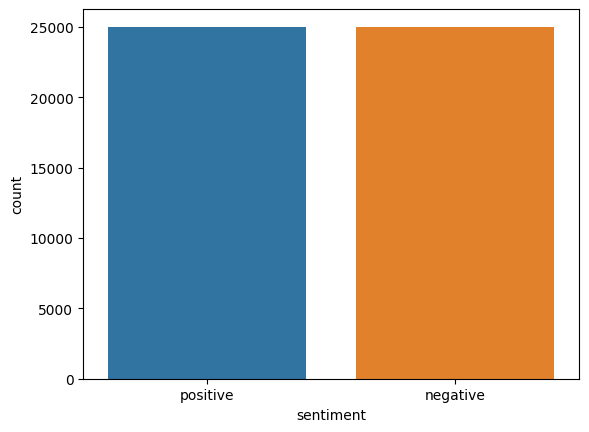

In [124]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [125]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [126]:
''' This effectively captures and matches HTML tags '''
#re.compile: This function is used to compile a regular expression pattern into a regex object, which can be later used for matching operations.
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    ''' function for removing  html tags with empty space'''

    return TAG_RE.sub('', text)

In [127]:
''' this is for importing stopwords . these are words which add no value to our analysis like article ,conjuction etc'''
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [128]:
''' function for cleaning'''

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    '''in lowercase'''

    sentence = sen.lower()

    # Remove html tags in this
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers in the sentence
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # removing Single character after 's
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces 's_=>___ good
    sentence = re.sub(r'\s+', ' ', sentence)

    # Removing Stopwords . This code efficiently removes English stopwords from the given sentence by using a
    # regular expression pattern based on the stopwords retrieved from NLTK. The \b ensures that only
    # whole words are matched, and the | separates individual stopwords in the pattern.
    # is|are|then|above
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [129]:
# Calling preprocessing_text function on each element of thevmovie_reviews dataset

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [130]:
# Therefore our dataset is now cleaned up

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [131]:
# Converting sentiment labels to 0 for 'negative' and 1 for 'positive'

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Here the training set will be used to train our models
# and the test set will be used to evaluate how well our model performs

## Preparing embedding layer

we will now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then used as the first layer for the deep learning models in Keras. As we know that deep learning models can only see or perform analysis on a numeric data or numeric parameter so we need to convert our textual data into a numeric form


Word embedding is a technique in natural language processing (NLP) and machine learning that represents words as dense vectors of real numbers in a continuous vector space. These vectors capture semantic relationships between words based on their context, allowing words with similar meanings to have similar vector representations.

The key idea behind word embeddings is to represent words in a way that preserves their semantic meaning and relationships. Traditional methods, such as one-hot encoding, represent each word as a sparse binary vector, which lacks semantic information and struggles to capture similarities between words.

Word embeddings are often learned from large amounts of text data using unsupervised learning techniques. Popular methods for generating word embeddings include Word2Vec, GloVe (Global Vectors for Word Representation), and FastText. These methods consider the context in which words appear and aim to position words with similar meanings closer together in the embedding space.

Word embeddings have become a fundamental component of many NLP applications, including sentiment analysis, machine translation, and information retrieval, as they provide a more nuanced representation of word semantics compared to traditional methods.


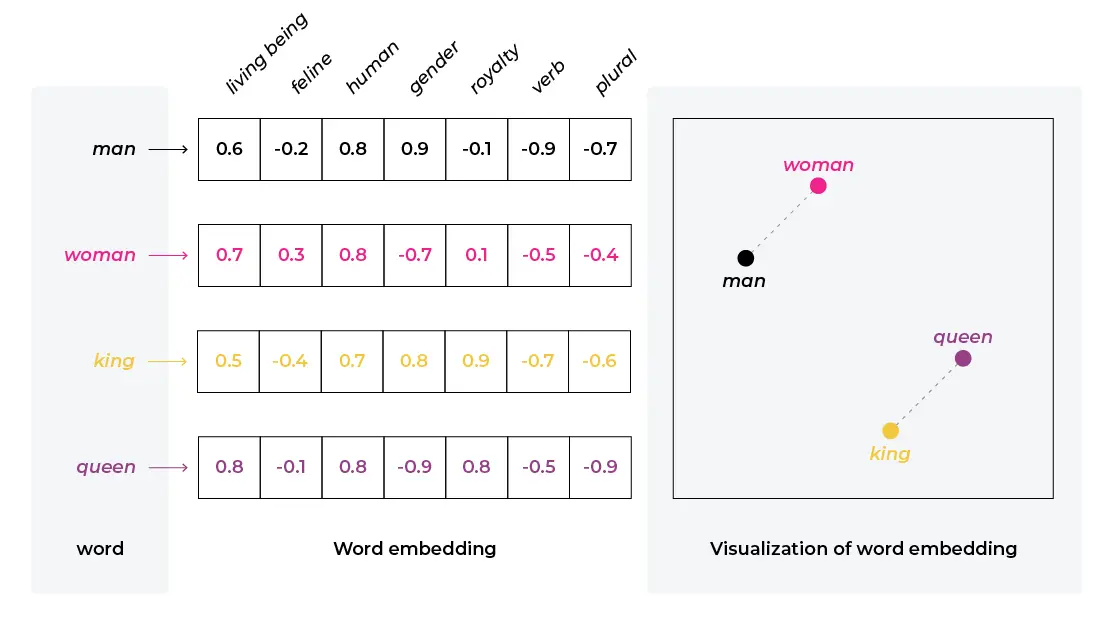


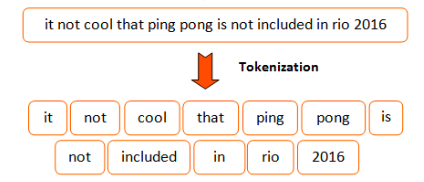

In [133]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library

# Method fit_on_text used in fitting the tokenizer on the training data (X_train).
# This step updates the internal vocabulary based on the words present in the training data.

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
# Method texts_to_sequences used in transforming the text data in both the training set (X_train) and the test set (X_test) into sequences of integers.
# Each word in the text is replaced with its corresponding integer index from the vocabulary created during the fitting step.

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

#The texts_to_sequences method is used to transform both the training set (X_train) and the test set (X_test) into sequences of integers.
#Each word in the text is replaced with its corresponding integer index from the vocabulary created during the fitting step.
# This results in sequences of integers representing the words in the original text.

In [134]:
# Adding 1 is a common practice. It's usually done to account for the fact that the indices start from 1, not 0.
# By adding 1, you ensure that the index 0 can be reserved for special tokens, like padding.

vocab_length = len(word_tokenizer.word_index) + 1
# vocab_length: This variable now holds the total number of unique words in your vocabulary, plus 1.
vocab_length

92394

In [135]:
# Padding all reviews to fixed length 100
# integers with a fixed length of 100, achieved by either padding or truncating as necessary.
# This step is often necessary when working with neural networks, as they require input data of uniform length.

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



 Creating an Empty Matrix:
   - we are setting up an empty matrix to store word embeddings. Each word in your vocabulary will have a corresponding row in this matrix, and each row will contain a 100-dimensional vector.

 Filling the Matrix with GloVe Embeddings:
   - For each word in the vocabulary:
     - If the word has a GloVe (pre-trained word embeddings) vector available, we are putting that vector into the corresponding row of the matrix.
     - If the word doesn't have a GloVe vector, the corresponding row remains filled with zeros.


In [136]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [137]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


#If the embedding vector exists, assigns it to the corresponding row in the embedding_matrix.
#The row index is determined by the word's index in the tokenizer's word index.

In [138]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

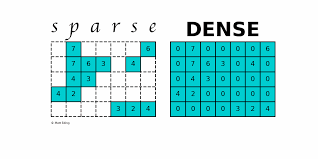

In [139]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
#Adds an embedding layer to the model. This layer is responsible for converting integer-encoded words into dense vectors (word embeddings).
snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [140]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [141]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.5576 - acc: 0.7158 - val_loss: 0.4980 - val_acc: 0.7591
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4464 - acc: 0.7979 - val_loss: 0.4898 - val_acc: 0.7660
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4116 - acc: 0.8166 - val_loss: 0.5053 - val_acc: 0.7642
Epoch 4/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3896 - acc: 0.8284 - val_loss: 0.5140 - val_acc: 0.7573
Epoch 5/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3740 - acc: 0.8383 - val_loss: 0.5258 - val_acc: 0.7534
Epoch 6/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3648 - acc: 0.8410 - val_loss: 0.5340 - val_acc: 0.7563


In [142]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5649 - acc: 0.7506


In [143]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5649399757385254
Test Accuracy: 0.7505999803543091


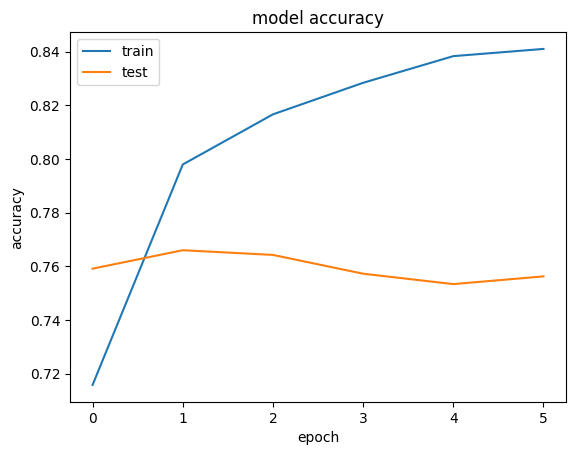

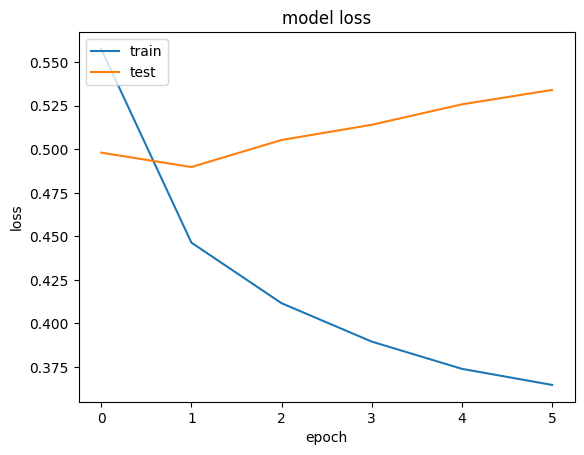

In [144]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Recurrent Neural Network (LSTM)

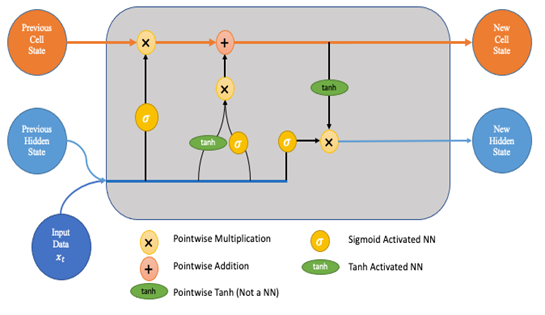


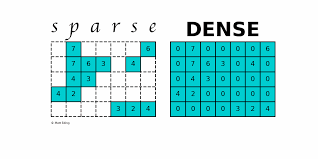

In [145]:
from keras.layers import LSTM

In [146]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)



#Adds an LSTM layer to the model with 128 units. LSTM layers are suitable for sequence processing tasks, such as natural language processing, where the order of words matters.
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [147]:
# Model compiling
#Optimizer (optimizer='adam'): Adam is an adaptive learning rate optimization algorithm. It adjusts the learning rates of each parameter during training
#Loss Function (loss='binary_crossentropy'): For binary classification tasks, binary crossentropy is commonly used as the loss function.
#It measures the difference between the predicted probabilities and the actual binary labels.
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_6 (LSTM)               (None, 128)               117248    
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [148]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 99s 383ms/step - loss: 0.4976 - acc: 0.7575 - val_loss: 0.4224 - val_acc: 0.8075
Epoch 2/6
250/250 [==============================] - 99s 396ms/step - loss: 0.4072 - acc: 0.8185 - val_loss: 0.3730 - val_acc: 0.8405
Epoch 3/6
250/250 [==============================] - 99s 396ms/step - loss: 0.3723 - acc: 0.8353 - val_loss: 0.3682 - val_acc: 0.8519
Epoch 4/6
250/250 [==============================] - 99s 398ms/step - loss: 0.3470 - acc: 0.8511 - val_loss: 0.3358 - val_acc: 0.8551
Epoch 5/6
250/250 [==============================] - 98s 393ms/step - loss: 0.3250 - acc: 0.8655 - val_loss: 0.3450 - val_acc: 0.8495
Epoch 6/6
250/250 [==============================] - 88s 352ms/step - loss: 0.3055 - acc: 0.8724 - val_loss: 0.3620 - val_acc: 0.8637


In [149]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 20s 63ms/step - loss: 0.3691 - acc: 0.8626


In [150]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.36907899379730225
Test Accuracy: 0.8626000285148621


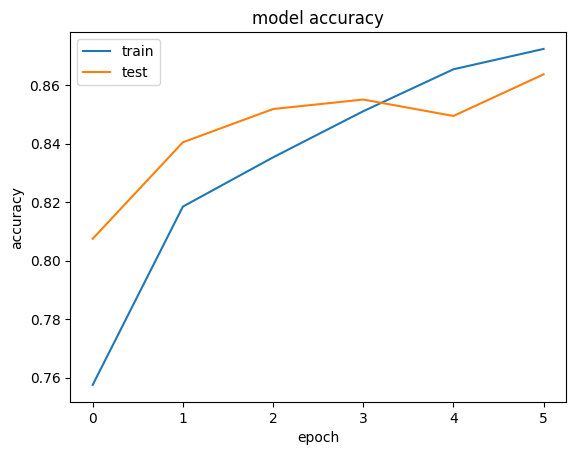

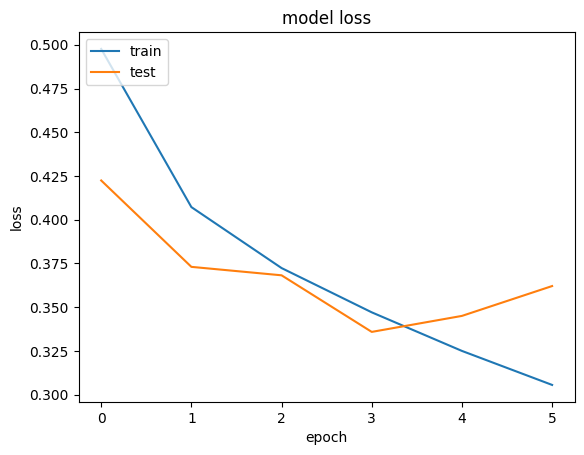

In [151]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [152]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [153]:
!ls # lists files in working directory

a1_IMDB_Dataset.csv   a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.863.h5	  index.ipynb
a2_glove.6B.100d.txt  c1_lstm_model_acc_0.507.h5  c2_IMDb_Unseen_Predictions.csv


In [154]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [155]:
# Loading the sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [156]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [157]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [158]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 695ms/step


array([[0.9455527 ],
       [0.9930571 ],
       [0.06466196],
       [0.97997934],
       [0.9835888 ],
       [0.00553475]], dtype=float32)

In [159]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.5
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.6
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,9.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1
